# Import libraries

In [1]:
import os
import h5py
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

# set file paths and get file directories

In [2]:
# Set up paths for IMERG and SEVIRI data folders
imerg_path = r"D:\Ghana\IMERG_data\Resampled_nat\Native\2021" #file path to your imerg files
seviri_path = r"D:\Ghana\SEVIRI_data\BT_native_to_hdf\2021" #file path to your seviri files

# Define output path
output_path = r'D:\Ghana\Merged_files_IMERG_SEVIRI\Test_year\2022' #define the output directory

The data is stored in directories per month so make sure to retrieve all the files for every month and set correct file path for each file

In [3]:
# Traverse through all subdirectories and files in the given path
imerg_files_path = []
for root, dirs, files in os.walk(imerg_path):
    for file in files:
        if file.endswith(".HDF5"):
            imerg_files_path.append(os.path.join(root, file))

# Traverse through all subdirectories and files in the given path
seviri_files_path = []
for root, dirs, files in os.walk(seviri_path):
    for file in files:
        if file.endswith(".hdf5"):
            seviri_files_path.append(os.path.join(root, file))         

# Define the time intervals to merge the files

In [4]:
# Define time interval of the IPW and the preceeding time taken into account for the estimation and output path
time_interval_ipw = timedelta(minutes = 2)
step_time_ipw = timedelta(minutes = 30) # step size of the window that looks for minimum and maxima
time_interval = timedelta(hours=2) # The time window one file contains prior to the event
time_offset = timedelta(minutes=3) # The offset the imerg and seviri files are allowed to have from the event to be predicted

# Set functions

To extract all the data within the seviri interval and the imerg interval

In [5]:
# Function to extract datetime from filename
def extract_datetime_seviri(filename):
    dt = datetime.strptime(filename.split('-')[5].split('.')[0], "%Y%m%d%H%M%S")
    return dt

def extract_datetime_imerg(filename):
    day = filename.split('.')[4].split('-')[0]
    hoday = filename.split('.')[4].split('-')[2][1:7]
    dt = datetime.strptime(day + hoday, "%Y%m%d%H%M%S")
    return dt

Functions to extract the files within a certain interval

In [6]:
# Function to find all files within a time interval
def get_files_in_interval_imerg(start_time, end_time, imerg_files):
    imerg_interval = [f for f in imerg_files if start_time <= extract_datetime_imerg(f) <= end_time]
    return imerg_interval

# Function to find all files within a time interval
def get_files_in_interval_seviri(start_time, end_time, seviri_files):
    seviri_interval = [f for f in seviri_files if start_time <= extract_datetime_seviri(f) <= end_time]
    return seviri_interval

# Function that defines the selection process

This function only works when you have a csv containing the dataframe with the selection criteria and is created with the 1.Retrieve_selection_criteria.ipynb

In [8]:
# Create a DataFrame
def filter_data(file, coverage_threshold, peak_threshold, fig_name, plot = False):
    df = pd.read_csv(file)
    df['time'] = pd.to_datetime(df['time'])
    
    filtered_df = df[(df['coverage'] > coverage_threshold) & (df['peak'] > peak_threshold) & (df['num_5mm'] > 4)]
    # display(filtered_df)
    print('number of events', len(filtered_df))

    if plot == True:
        # Group by year and month, count occurrences
        filtered_df['month'] = filtered_df['time'].dt.to_period('M')
        month_counts = df.groupby(filtered_df['month']).size()
        
        # Plot the data
        month_counts.plot(kind='bar', figsize=(5, 3), color='skyblue', edgecolor = 'k')
        plt.title('Number of Events per Month')
        plt.xlabel('Month')
        plt.ylabel('Number of Events')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.savefig(f'{fig_name}.png', bbox_inches = 'tight', dpi = 300)
        plt.show()

        # Extract hour and group by it
        filtered_df['hour'] = filtered_df['time'].dt.hour
        hourly_counts = df.groupby(filtered_df['hour']).size()
        
        # Plot the results
        hourly_counts.plot(kind='bar', figsize=(10, 5), color='skyblue', edgecolor = 'k')
        plt.title('Number of Events per Hour of the Day')
        plt.xlabel('Hour of the Day')
        plt.ylabel('Number of Events')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.show()
    return filtered_df

# Show selected events

number of events 2429


C:\Users\c.kwa\AppData\Local\Temp\ipykernel_26180\1157572225.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['month'] = filtered_df['time'].dt.to_period('M')


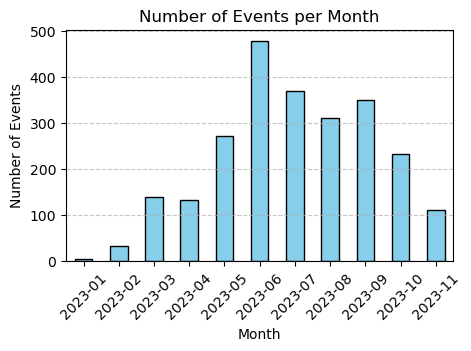

C:\Users\c.kwa\AppData\Local\Temp\ipykernel_26180\1157572225.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['hour'] = filtered_df['time'].dt.hour


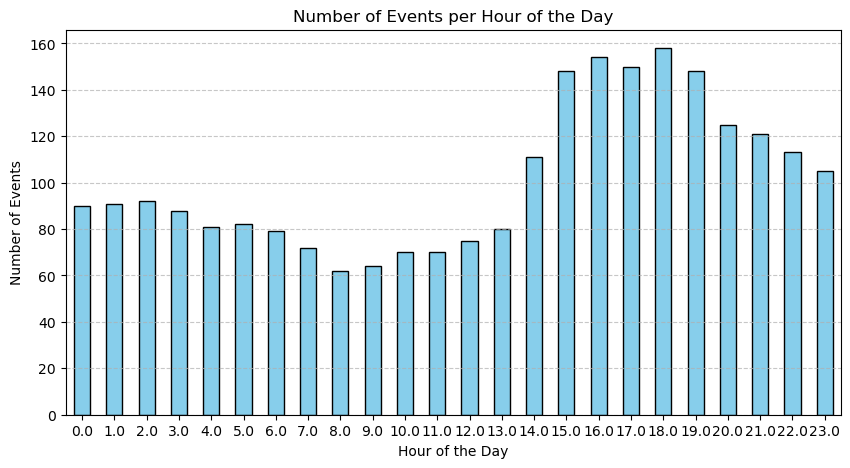

In [12]:
filtered_df_2022 = filter_data('values_2022_version4.csv', 0.02, 20, 'event_distribuion_months_2022', True)

# Merging IMERG and SEVIRI data into one file for the selected events
This is done so the ML model can handle the data. 

In [16]:
channel_names = ['VIS006', 'VIS008', 'IR_016', 'IR_039', 'WV_062', 'WV_073', 'IR_087', 'IR_097', 'IR_108', 'IR_120', 'IR_134']

In [17]:
filtered_df_2022 = filter_data('values_2022_version4.csv', 0.02, 20)

for time in filtered_df_2022['time']:

    # Define output filename based on interval start time
    output_filename = os.path.join(output_path, f"Combined_{time.strftime('%Y%m%d%H%M%S')}.hdf5")
    print(output_filename)

    if not os.path.exists(output_filename):
        imerg_interval = get_files_in_interval_imerg(time, time, imerg_files_path)
        seviri_interval = get_files_in_interval_seviri(time - time_interval - time_offset, time, seviri_files_path)
        # print(imerg_interval)
        # print(seviri_interval)
        # print(len(seviri_interval))
    
        if len(seviri_interval) == int(((time_interval) / timedelta(minutes = 15))) + 1 and len(imerg_interval) > 0:
            print(time)
    
            try:    
                # Create output HDF5 file
                with h5py.File(output_filename, "w") as out_file:
                    
                    # Process IMERG data
                    imerg_data = []
                    for file in imerg_interval:
                        with h5py.File(os.path.join(imerg_path, file), "r") as imerg_file:
                            imerg_data.append(imerg_file["IMERG_FR"][:])  # Assuming IMERG_FR is the dataset
                    
                    # Stack IMERG data along the time axis
                    imerg_data = np.stack(imerg_data, axis=0)  # Shape: (time, height, width)
                    out_file.create_dataset("IMERG", data=imerg_data, dtype='float32')
                    
                    # Process SEVIRI data
                    seviri_data = {f"{channel_names[i]}": [] for i in range(len(channel_names))}
                    for file in seviri_interval:
                        with h5py.File(os.path.join(seviri_path, file), "r") as seviri_file:
                            for i in range(len(channel_names)):  # channels 1-11
                                seviri_data[f"{channel_names[i]}"].append(np.flip(seviri_file[f"{channel_names[i]}"][:], axis = 0))
                                
                    #print(seviri_data)
                    # Stack SEVIRI data and create SEVIRI dataset
                    for channel in seviri_data.keys():
                        seviri_data[channel] = np.stack(seviri_data[channel], axis=0)  # Shape: (time, height, width)
                    
                    # Stack all SEVIRI channels along the channel axis
                    seviri_data_stacked = np.stack([seviri_data[f"{channel_names[i]}"] for i in range(len(channel_names))], axis=-1)  # (time, height, width, channel)
                    out_file.create_dataset("SEVIRI", data=seviri_data_stacked, dtype='float32')

            except:
                print(f'{output_filename} is incomplete')

number of events 1744
D:\Ghana\Merged_files_IMERG_SEVIRI\Condition_set_0.02_20_all_no_vis\2021\Combined_20210104032959.hdf5
2021-01-04 03:29:59
D:\Ghana\Merged_files_IMERG_SEVIRI\Condition_set_0.02_20_all_no_vis\2021\Combined_20210104035959.hdf5
2021-01-04 03:59:59
D:\Ghana\Merged_files_IMERG_SEVIRI\Condition_set_0.02_20_all_no_vis\2021\Combined_20210104155959.hdf5
2021-01-04 15:59:59
D:\Ghana\Merged_files_IMERG_SEVIRI\Condition_set_0.02_20_all_no_vis\2021\Combined_20210104162959.hdf5
2021-01-04 16:29:59
D:\Ghana\Merged_files_IMERG_SEVIRI\Condition_set_0.02_20_all_no_vis\2021\Combined_20210104165959.hdf5
2021-01-04 16:59:59
D:\Ghana\Merged_files_IMERG_SEVIRI\Condition_set_0.02_20_all_no_vis\2021\Combined_20210104172959.hdf5
2021-01-04 17:29:59
D:\Ghana\Merged_files_IMERG_SEVIRI\Condition_set_0.02_20_all_no_vis\2021\Combined_20210104175959.hdf5
2021-01-04 17:59:59
D:\Ghana\Merged_files_IMERG_SEVIRI\Condition_set_0.02_20_all_no_vis\2021\Combined_20210104182959.hdf5
2021-01-04 18:29:59
D: